# Classifieurs - Spotify Best Songs from 2000 to 2023
-> Prédiction du genre des musiques populaires de 2000 à 2023

- SCHERRER Arthur
- CHIRON Yoann
- BOQUAIN Mathis

### Import des différentes librairies

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
from sklearn.metrics import classification_report
from collections import defaultdict

### Chargement des données

In [3]:
data = pd.read_csv("spotify_songs.csv", sep=';')

### Affichage

In [4]:
df = pd.DataFrame(data)
new_df = df.iloc[:, 3:].copy()
df.head()

,title,artist,top genre,year,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,Flowers,Miley Cyrus,pop,2023,118,68,71,65,200,6,7
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,73,174,44,3
2,BESO,ROSALÍA,pop,2023,95,64,77,53,195,74,14
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,86,131,25,5
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,17,222,42,5


### Discrétisation des données

Certaines features ont été supprimées où ne sont pas utilisées car peu de pertinences face au sujet étudié :
- dB
- liveness
- popularity : tous les morceaux sont populaires

#### Feature à discrétiser

- genre
- bpm
- danceability
- energy
- valence
- acousticness
- speechiness
- year 
- duration

### Discrétisation du genre

In [329]:
def gender_discresation(df):
     """discrétisation du genre

     Args:
         df (_type_): la dataFrame : nos données

     Returns:
         _type_: les données discrétisées
     """

     df.sort_values(by="top genre")

     df['top genre'] = df['top genre'].str.replace('.*pop.*', 'pop', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*hip hop.*', 'rap', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*hip-hop.*', 'rap', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*rap.*', 'rap', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*metal.*', 'metal', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*r&b.*', 'r&b', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*edm.*', 'techno', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*electro.*', 'techno', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*electro dance music.*', 'techno', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*indie.*', 'indian', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*rock.*', 'rock', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*house.*', 'techno', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*jazz.*', 'jazz', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*mellow.*', 'rock', regex=True)
     df['top genre'] = df['top genre'].str.replace('.*soul.*', 'soul', regex=True)

     genres_to_keep = ['pop', 'rap', 'metal', 'r&b', 'techno', 'rock']
     mask = df['top genre'].isin(genres_to_keep)
     df = df[mask]

     df['top genre'].value_counts()
     
     return df

df = gender_discresation(df)

df.head()

,title,artist,top genre,year,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,Flowers,Miley Cyrus,pop,2023,118,68,71,65,200,6,7
1,Cupid - Twin Ver.,FIFTY FIFTY,pop,2023,120,59,78,73,174,44,3
2,BESO,ROSALÍA,pop,2023,95,64,77,53,195,74,14
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,17,222,42,5
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,53,201,13,5


### Méthode de discrétisation

In [330]:
def discretize_column(df, column_name, num_intervals, labels=None):
    """
    Discrétise une colonne de données dans un DataFrame en fonction d'un nombre d'intervalles spécifié.

    Args:
    - df : DataFrame contenant les données
    - column_name : Nom de la colonne à discrétiser
    - num_intervals : Nombre d'intervalles souhaité
    - labels : Liste des labels pour les catégories discrétisées

    Returns:
    - Un DataFrame avec la colonne initiale remplacée par les données discrétisées
    """

    # Calcul des quantiles en fonction du nombre d'intervalles
    quantiles = [i / num_intervals for i in range(num_intervals)]

    # Calcul des valeurs des quantiles
    quantiles_values = df[column_name].quantile(quantiles)

    # Définition des intervalles
    intervals = [df[column_name].min()] + list(quantiles_values.unique()) + [df[column_name].max()]

    # Définition des labels si spécifiés, sinon utiliser les intervalles comme labels
    if labels is None:
        labels = [f"Interval {i+1}" for i in range(len(quantiles) + 1)]

    # Discrétisation de la colonne en supprimant les bords d'intervalles en double
    df[column_name] = pd.cut(df[column_name], bins=intervals, labels=labels, include_lowest=True, duplicates='drop')

    return df

df = discretize_column(df, 'bpm', num_intervals=4, labels=['Low bpm', 'Medium bpm', 'High bpm', 'Very High bpm'])
df = discretize_column(df, 'danceability', num_intervals=4, labels=['Low Danceability', 'Moderate Danceability', 'High Danceability', 'Very High Danceability'])
df = discretize_column(df, 'energy', num_intervals=4, labels=['Low Energy', 'Moderate Energy', 'High Energy', 'Very High Energy'])
df = discretize_column(df, 'valence', num_intervals=3, labels=['negative', 'neutral', 'positive'])
df = discretize_column(df, 'acousticness', num_intervals=4, labels= ['Low Acousticness', 'Moderate Acousticness', 'High Acousticness', 'Very High Acousticness'])
df = discretize_column(df, 'speechiness', num_intervals=4, labels=['Low Speechiness', 'Moderate Speechiness', 'High Speechiness', 'Very High Speechiness'])
df = discretize_column(df, 'year', num_intervals=3, labels=["2000's","2010's", "2020's"])
df = discretize_column(df, 'duration', num_intervals=3, labels=['short', 'medium', 'long'])

df.head()

,title,artist,top genre,year,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,Flowers,Miley Cyrus,pop,2020's,Medium bpm,Moderate Energy,High Danceability,neutral,short,Moderate Acousticness,High Speechiness
1,Cupid - Twin Ver.,FIFTY FIFTY,pop,2020's,Medium bpm,Low Energy,Very High Danceability,positive,short,Very High Acousticness,Low Speechiness
2,BESO,ROSALÍA,pop,2020's,Low bpm,Moderate Energy,High Danceability,neutral,short,Very High Acousticness,Very High Speechiness
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2020's,Low bpm,Moderate Energy,High Danceability,negative,medium,Very High Acousticness,Moderate Speechiness
8,Anti-Hero,Taylor Swift,pop,2020's,Low bpm,Moderate Energy,Moderate Danceability,neutral,short,High Acousticness,Moderate Speechiness


### Séparation du dataset 

In [331]:
x = df[['bpm','danceability','energy','valence','acousticness','speechiness','year','duration']]
y = df['top genre']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=101)

df

,title,artist,top genre,year,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,Flowers,Miley Cyrus,pop,2020's,Medium bpm,Moderate Energy,High Danceability,neutral,short,Moderate Acousticness,High Speechiness
1,Cupid - Twin Ver.,FIFTY FIFTY,pop,2020's,Medium bpm,Low Energy,Very High Danceability,positive,short,Very High Acousticness,Low Speechiness
2,BESO,ROSALÍA,pop,2020's,Low bpm,Moderate Energy,High Danceability,neutral,short,Very High Acousticness,Very High Speechiness
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2020's,Low bpm,Moderate Energy,High Danceability,negative,medium,Very High Acousticness,Moderate Speechiness
8,Anti-Hero,Taylor Swift,pop,2020's,Low bpm,Moderate Energy,Moderate Danceability,neutral,short,High Acousticness,Moderate Speechiness
...,...,...,...,...,...,...,...,...,...,...,...
2374,NOT AFRAID,Kodiro,rap,2020's,Low bpm,Low Energy,High Danceability,negative,short,Moderate Acousticness,Low Speechiness
2375,Pop Ya Collar - Radio Edit,Usher,rap,2020's,Medium bpm,High Energy,Very High Danceability,positive,medium,High Acousticness,High Speechiness
2379,Southbound,Beach Blvd,rock,2020's,Very High bpm,Very High Energy,Low Danceability,neutral,medium,High Acousticness,Low Speechiness
2382,Scared of the Dark,Everything Brighter,pop,2020's,Medium bpm,High Energy,Moderate Danceability,neutral,short,Low Acousticness,Moderate Speechiness


### Méthodes d'évaluation

In [332]:
def evaluate(Class_true, Class_pred):
    acc = accuracy(Class_true, Class_pred)
    prec = precision(Class_true, Class_pred)
    rap = rappel(Class_true, Class_pred)
    return acc, prec, rap

def accuracy(Class_true, Class_pred):
    correct = sum(1 for true, pred in zip(Class_true, Class_pred) if true == pred)
    total = len(Class_pred)
    return "accuracy =  " + str(correct / total * 100) + "%"

def precision(Class_true, Class_pred):
    unique_values = np.unique(Class_true)
    n = 0
    for value in unique_values:
        correct = sum(1 for true, pred in zip(Class_true, Class_pred) if true == pred == value)
        total = sum(1 for pred in Class_pred if pred == value)
        if total != 0 :
            n += correct / total
    return "précision =  " + str(n / len(unique_values) * 100) + "%"

def rappel(Class_true, Class_pred):
    unique_values = np.unique(Class_true)
    n = 0
    for value in unique_values:
        correct = sum(1 for true, pred in zip(Class_true, Class_pred) if true == pred == value)
        total = sum(1 for true in Class_true if true == value)
        if total != 0 :
            n += correct / total
    return "rappel =  " + str(n / len(unique_values) * 100) + "%"

# Supervisé

### ZeroR

In [333]:
def learn_zeror(x_train, y_train):
    unique_labels, counts = np.unique(y_train, return_counts=True)

    # Trouvez l'indice de l'étiquette avec le nombre le plus élevé
    index_max_count = np.argmax(counts)
    
    # L'étiquette avec le nombre le plus élevé est à l'indice index_max_count
    most_common_label = unique_labels[index_max_count]
    
    return most_common_label 

def class_zeror(model, x_test):
    return [model]* len(x_test)

In [334]:
learn_zeror(x_train, y_train)

pred2 = class_zeror(learn_zeror(x_train, y_train), x_test)

report = classification_report(y_test, pred2, zero_division=0)

print(report)

evaluate(y_test, pred2)

              precision    recall  f1-score   support

       metal       0.00      0.00      0.00        10
         pop       0.55      1.00      0.71       211
         r&b       0.00      0.00      0.00        20
         rap       0.00      0.00      0.00        90
        rock       0.00      0.00      0.00        24
      techno       0.00      0.00      0.00        29

    accuracy                           0.55       384
   macro avg       0.09      0.17      0.12       384
weighted avg       0.30      0.55      0.39       384



('accuracy =  54.947916666666664%',
 'précision =  9.15798611111111%',
 'rappel =  16.666666666666664%')

### OneR Mathis

In [335]:
def learn_oner(x_train_dis, y_train_dis):
    best_feature = None
    best_error_rate = 1.0
    best_rules = {}

    for feature in x_train_dis.columns:
        unicClasses = y_train_dis.unique()
        best_rule = {}
        
        for value in x_train_dis[feature].unique():
            value_counts = {}
            for class_ in unicClasses:
                value_counts[class_] = len(y_train_dis[(x_train_dis[feature] == value) & (y_train_dis == class_)])

            best_class = max(value_counts, key=value_counts.get)
            best_rule[value] = best_class

        # Calculer le taux d'erreur pour cette caractéristique
        error_rate = 0
        for value in x_train_dis[feature].unique():
            error_rate += len(y_train_dis[(x_train_dis[feature] == value) & (y_train_dis != best_rule[value])])

        error_rate /= len(x_train_dis)

        if error_rate < best_error_rate:
            best_error_rate = error_rate
            best_feature = feature
            best_rules = best_rule

    return {best_feature: best_rules}

def class_oner(model, x_test_dis):
    predictions = []
    feature = list(model.keys())[0]

    for index, row in x_test_dis.iterrows():
        feature_value = row[feature]
        if feature_value in model[feature]:
            predicted_class = model[feature][feature_value]
            predictions.append(predicted_class)
    return pd.Series(predictions)

evaluate(y_test,class_oner(learn_oner(x_train, y_train),x_test))

('accuracy =  58.59375%',
 'précision =  18.470211565260453%',
 'rappel =  23.08232403019133%')

### Naïve Bayes - Arthur

-> on travaille uniquement avec des valeurs numériques

In [336]:
df = pd.DataFrame(data)

df = df.drop('title', axis=1)
df = df.drop('artist', axis=1)
df = df.drop('year', axis=1)

df = gender_discresation(df)

df.head()

,top genre,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,pop,118,68,71,65,200,6,7
1,pop,120,59,78,73,174,44,3
2,pop,95,64,77,53,195,74,14
4,rap,98,62,72,17,222,42,5
8,pop,97,64,64,53,201,13,5


In [337]:
def gaussian_probability(x, mean, std):
    """donne la proba qu'une VA prenne une valeur spécifique compte tenu de la moyenne et de l'écart-type d'une distri gaussienne

    Args:
        x (_type_): la variable
        mean (_type_): la moyenne
        std (_type_): l'ecart-type

    Returns:
        int: une proba
    """
    exponent = np.exp(-(np.power(x - mean, 2) / (2 * np.power(std, 2))))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

#### Train

In [338]:
def train_NB(X_train, y_train):
    """estimee les probabilités nécessaires pour la classification Naive Bayes

    Args:
        X_train (_type_): les données
        y_train (_type_): les étiquettes

    Returns:
        dict, dict: un dictionnaire qui stocke les probas, et un dictionnaire qui stocke les stats des features pour chaque classe
    """
    unicClasses = np.unique(y_train)
    classProbs = {}
    featureProbs = {}

    for target in unicClasses:
        class_indices = (y_train == target)
        classProbs[target] = np.sum(class_indices) / len(y_train)
        featureProbs[target] = {
            'mean': np.mean(X_train[class_indices], axis=0),
            'std': np.std(X_train[class_indices], axis=0) + 1e-8  # pour éviter une division par zéro
        }

    return classProbs, featureProbs

#### Prediction

In [339]:
def predict(instance, classProbs, featureProbs):
    """effectue une prédiction en utilisant un modèle Naive Bayes entraîné

    Args:
        instance (_type_): les données
        classProbs (_type_): probabilités a priori de chaque classe
        featureProbs (_type_): statistiques des caractéristiques pour chaque classe

    Returns:
        string: classe prédite pour l'instance donnée
    """
    predicted = None
    max_posterior_prob = -1

    for target, class_prob in classProbs.items():
        posterior_prob = np.log(class_prob)

        for i, feature_value in enumerate(instance):
            mean = featureProbs[target]['mean'][i]
            std = featureProbs[target]['std'][i]

            posterior_prob += np.log(gaussian_probability(feature_value, mean, std))

        if posterior_prob > max_posterior_prob or predicted is None:
            max_posterior_prob = posterior_prob
            predicted = target

    return predicted


#### Test

In [340]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_data[['bpm', 'energy', 'danceability', 'valence', 'duration', 'acousticness', 'speechiness']].values
y_train = train_data['top genre'].values
X_test = test_data[['bpm', 'energy', 'danceability', 'valence', 'duration', 'acousticness', 'speechiness']].values

classProbs, featureProbs = train_NB(X_train, y_train)

predictions = [predict(instance, classProbs, featureProbs) for instance in X_test]

report = classification_report(test_data['top genre'], predictions)
print(report)

              precision    recall  f1-score   support

       metal       0.27      0.56      0.36        18
         pop       0.62      0.77      0.68       216
         r&b       0.00      0.00      0.00        15
         rap       0.58      0.41      0.48        92
        rock       0.33      0.04      0.07        25
      techno       0.10      0.06      0.07        18

    accuracy                           0.56       384
   macro avg       0.32      0.31      0.28       384
weighted avg       0.53      0.56      0.53       384



### KPPV

In [308]:
#discretisation des classes
df = pd.DataFrame(data)

df = gender_discresation(df)

x = df[['bpm','danceability','energy','valence','acousticness','speechiness','year','duration']]
y = df['top genre']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=101)

In [309]:
#centrer reduire
means_train = np.mean(x_train, axis=0)
stds_train = np.std(x_train, axis=0)

train_std = (x_train - means_train) / stds_train

means_test = np.mean(x_test, axis=0)
stds_test = np.std(x_test, axis=0)

test_std = (x_test - means_test) / stds_test


In [310]:
#implémentation de kppv avec distance euclidienne
def euclidean_distance(array1, array2):
    squared_diff = np.square(array1 - array2)
    sum_squared_diff = np.sum(squared_diff)
    return np.sqrt(sum_squared_diff)

def k_nearest_neighbors(X_train, Y_train, X_test, k=6):
    y_pred = []
    for x in X_test.values:
        distances = [euclidean_distance(x, x_train) for x_train in X_train.values]
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [Y_train.values[i] for i in k_indices]

        label_counts = dict()
        for label in k_nearest_labels:
            label_counts[label] = label_counts.get(label, 0) + 1

        most_common_labels = [label for label, count in label_counts.items() if count == max(label_counts.values())]
        predicted_label = choice(most_common_labels)

        y_pred.append(predicted_label)
    return np.array(y_pred)


In [311]:
#test

pred = k_nearest_neighbors(train_std, y_train, test_std)

eval_kppv = evaluate(y_test, pred)

print(eval_kppv)

report_kppv = classification_report(y_test, pred)

print(report_kppv)

('accuracy =  58.333333333333336%', 'précision =  41.29905388728918%', 'rappel =  34.294910206823914%')
              precision    recall  f1-score   support

       metal       0.31      0.40      0.35        10
         pop       0.63      0.82      0.71       211
         r&b       0.00      0.00      0.00        20
         rap       0.53      0.40      0.46        90
        rock       0.40      0.17      0.24        24
      techno       0.62      0.28      0.38        29

    accuracy                           0.58       384
   macro avg       0.41      0.34      0.35       384
weighted avg       0.55      0.58      0.55       384



-> on supprime les données textuelles pour travailler uniquement sur les données numériques

In [341]:
df = pd.DataFrame(data)

df = df.drop('title', axis=1)
df = df.drop('artist', axis=1)
df = df.drop('year', axis=1)

df = gender_discresation(df)

df.head()

,top genre,bpm,energy,danceability,valence,duration,acousticness,speechiness
0,pop,118,68,71,65,200,6,7
1,pop,120,59,78,73,174,44,3
2,pop,95,64,77,53,195,74,14
4,rap,98,62,72,17,222,42,5
8,pop,97,64,64,53,201,13,5


In [342]:
def dist_euclidienne(point1, point2):
    """calcule la distance euclienne entre 2 points

    Args:
        point1 (_type_): le point 1
        point2 (_type_): le point 2

    Returns:
        int: la distance euclidienne entre les 2 points
    """
    return np.sqrt(np.sum((point1 - point2)**2))

#### Méthode de calcul des k plus proches voisins

In [343]:
def KPPV(train_data, labels, new_point, k=6):
    """effectue la classification d'une nouvelle instance

    Args:
        train_data (_type_): les données de train
        labels (_type_): étiquettes de classe correspondant aux exemples d'apprentissage
        new_point (_type_): caractéristiques de la nouvelle instance à classer
        k (int, optional): nombre de voisins à considérer

    Returns:
        _type_: classe prédite pour la nouvelle instance
    """
    distances = [dist_euclidienne(new_point, train_point) for train_point in train_data]
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = [labels[i] for i in nearest_indices]
    most_common_label = Counter(nearest_labels).most_common(1)[0][0]
    return most_common_label

#### Test

In [344]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_data[['bpm', 'energy', 'danceability', 'valence', 'duration', 'acousticness', 'speechiness']].values
y_train = train_data['top genre'].values
X_test = test_data[['bpm', 'energy', 'danceability', 'valence', 'duration', 'acousticness', 'speechiness']].values

predictions = [KPPV(X_train, y_train, test_point) for test_point in X_test]

report = classification_report(test_data['top genre'], predictions)
print(report)

              precision    recall  f1-score   support

       metal       0.40      0.11      0.17        18
         pop       0.63      0.86      0.73       216
         r&b       0.10      0.07      0.08        15
         rap       0.76      0.45      0.56        92
        rock       0.07      0.04      0.05        25
      techno       0.22      0.11      0.15        18

    accuracy                           0.60       384
   macro avg       0.36      0.27      0.29       384
weighted avg       0.58      0.60      0.57       384



# Non Supervisé

### K-means Mathis Boquain

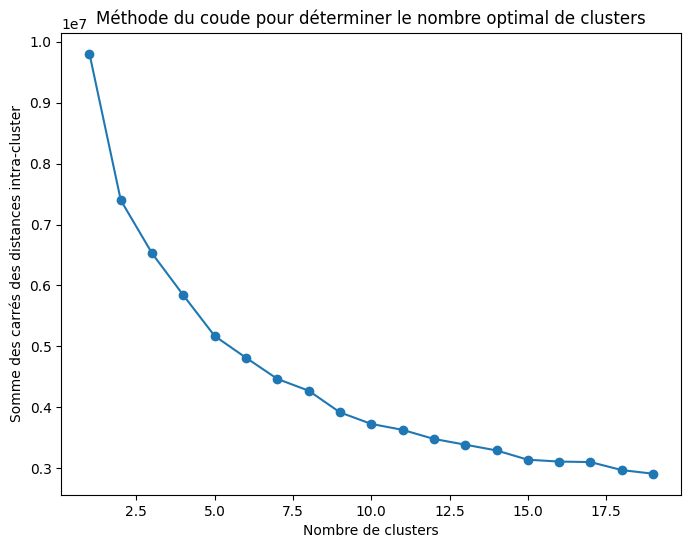

In [5]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

def initialize_centroids(X, k):
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]
    return centroids

# Fonction pour attribuer chaque point au centroïde le plus proche
def assign_to_nearest(X, centroids):
    clusters = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        clusters[i] = np.argmin(distances)
    return clusters

# Fonction pour mettre à jour les centroides
def update_centroids(X, clusters, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[clusters == i]
        centroids[i] = np.mean(cluster_points, axis=0)
    return centroids

# Fonction d'algorithme de k-moyennes
def k_means(X, k, max_iterations=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iterations):
        prev_centroids = centroids.copy()
        clusters = assign_to_nearest(X, centroids)
        centroids = update_centroids(X, clusters, k)
        if np.all(prev_centroids == centroids):
            break
    return clusters, centroids

# Application de l'algorithme de k-moyennes à l'ensemble de données Iris
k_values = range(1, 20)
wcss_values = []

new_df.reset_index(drop=True, inplace=True)  # Réinitialiser complètement l'index

# Réinitialiser les données après l'opération précédente
X_music = new_df.values

# Utiliser les données réinitialisées pour l'algorithme de K-moyennes
k_values = range(1, 20)
wcss_values = []

for k in k_values:
    clusters, centroids = k_means(X_music, k)
    wcss = np.sum((X_music - centroids[clusters.astype(int)]) ** 2)
    wcss_values.append(wcss)
    
# Affichage du graphique pour la méthode du coude
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss_values, marker='o', linestyle='-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-cluster')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()